In [66]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
import matplotlib.pyplot as plt 

%matplotlib inline
from scipy import stats
from statsmodels.graphics.api import qqplot

In [113]:
n =100

y = np.zeros(n) 
x = np.zeros(n) 

for i in range(0,n):
    
    e = np.random.normal(0, 2, 1)
    
#     y[i] = 1.5 + y[i - 1] + e
    
    x[i] = i + e

In [114]:
y=x

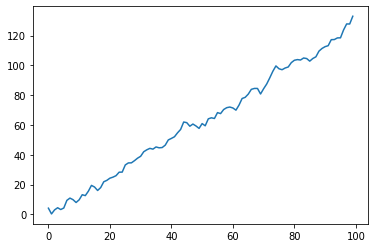

In [84]:
y=pd.Series(y)
dy=y.diff(periods=1)
y.plot()

In [115]:
df=pd.DataFrame(y)
df.index = pd.period_range('2002-01-01', '2010-04-01', freq='M')
df=df.rename(columns={0:'y'})
y =df['y']

In [116]:
df

,y
2002-01,1.393818
2002-02,2.115928
2002-03,4.349357
2002-04,3.504709
2002-05,4.432536
...,...
2009-12,91.168202
2010-01,95.875043
2010-02,98.079755
2010-03,96.070269


In [51]:
df.to_csv(r'y.csv')

In [122]:
# Generar el modelo
model = sm.tsa.SARIMAX(y, order=(1,0,0), trend='c')

# Estimar los parametros del modelo
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -251.244
Date:                Mon, 29 Jun 2020   AIC                            508.488
Time:                        14:36:58   BIC                            516.303
Sample:                    01-31-2002   HQIC                           511.651
                         - 04-30-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0999      0.506      0.197      0.844      -0.893       1.092
ar.L1          0.9980      0.011     94.656      0.000       0.977       1.019
sigma2         8.4299      1.382      6.100      0.0

In [123]:
training_obs = int(len(y) * 0.8)

training_y = y[:training_obs]

# Establecer el numero de pronosticos
nforecasts = 3
forecasts = {}

# Obtener el numero de observaciones del training initial
nobs = len(y)
n_init_training = int(nobs * 0.8)

# Crear el model para estimar con la muestra del initial training sample
init_training_y = y.iloc[:n_init_training]
mod = sm.tsa.SARIMAX(training_y, order=(1, 0, 0), trend='c')
res = mod.fit()

# Guardar los pronosticos inicialest
forecasts[training_y.index[-1]] = res.forecast(steps=nforecasts)

# Realizar el procedimiento al resto de la muestra
for t in range(n_init_training, nobs):
    # Actualizar los resultados mediante el agregar una observacion adicional
    updated_y = y.iloc[t:t+1]
    res = res.append(updated_y, refit=False)

    # Guardar los nuevos resultados
    forecasts[updated_y.index[0]] = res.forecast(steps=nforecasts)

# Combinar todos los pronosticos dentro de un dataframe
forecasts = pd.concat(forecasts, axis=1)

print(forecasts.iloc[:10, :7])
# print(forecasts)

           2008-08    2008-09    2008-10    2008-11    2008-12    2009-01  \
2008-09  78.658655        NaN        NaN        NaN        NaN        NaN   
2008-10  78.545172  79.819102        NaN        NaN        NaN        NaN   
2008-11  78.432022  79.702213  79.702213        NaN        NaN        NaN   
2008-12        NaN  79.585666  79.585666  79.585666        NaN        NaN   
2009-01        NaN        NaN  79.469462  79.469462  79.469462        NaN   
2009-02        NaN        NaN        NaN  79.353599  79.353599  79.353599   
2009-03        NaN        NaN        NaN        NaN  79.238076  79.238076   
2009-04        NaN        NaN        NaN        NaN        NaN  79.122892   
2009-05        NaN        NaN        NaN        NaN        NaN        NaN   
2009-06        NaN        NaN        NaN        NaN        NaN        NaN   

           2009-02  
2008-09        NaN  
2008-10        NaN  
2008-11        NaN  
2008-12        NaN  
2009-01        NaN  
2009-02        NaN  
2009-

In [124]:
# Construir los errores de pronosticos
forecast_errors = forecasts.apply(lambda column: y - column).reindex(forecasts.index)

print(forecast_errors.iloc[:10, :5])

          2008-08   2008-09   2008-10   2008-11   2008-12
2008-09  1.277681       NaN       NaN       NaN       NaN
2008-10  4.454412  3.180481       NaN       NaN       NaN
2008-11  1.590270  0.320079  0.320079       NaN       NaN
2008-12       NaN  7.818054  7.818054  7.818054       NaN
2009-01       NaN       NaN  5.843096  5.843096  5.843096
2009-02       NaN       NaN       NaN  6.893065  6.893065
2009-03       NaN       NaN       NaN       NaN  5.033412
2009-04       NaN       NaN       NaN       NaN       NaN
2009-05       NaN       NaN       NaN       NaN       NaN
2009-06       NaN       NaN       NaN       NaN       NaN


In [125]:
# Reindex los pronosticos en funcion de los horizonte
def flatten(column):
    return column.dropna().reset_index(drop=True)

forecast_horizon = forecast_errors.apply(flatten)
forecast_horizon.index = (forecast_horizon.index + 1).rename('horizon')

print(forecast_horizon.iloc[:3, :5])

          2008-08   2008-09   2008-10   2008-11   2008-12
horizon                                                  
1        1.277681  3.180481  0.320079  7.818054  5.843096
2        4.454412  0.320079  7.818054  5.843096  6.893065
3        1.590270  7.818054  5.843096  6.893065  5.033412


In [126]:
# Calcular la raiz del mean square error
rmse = (forecast_horizon**2).mean(axis=1)**0.5

print(rmse)

horizon
1    12.284470
2    12.620488
3    12.928957
dtype: float64


In [53]:
# Generar el modelo
model = sm.tsa.SARIMAX(y, order=(1,0,0), trend='c')

# Estimar los parametros del modelo
results = model.fit()

print(results.summary())

C:\Users\lfsanche\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -239.904
Date:                Mon, 29 Jun 2020   AIC                            485.808
Time:                        13:47:27   BIC                            493.624
Sample:                             0   HQIC                           488.971
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0416      0.433      0.096      0.923      -0.806       0.890
ar.L1          0.9995      0.006    180.123      0.000       0.989       1.010
sigma2         6.6304      1.017      6.522      0.0

In [ ]:
fcast_res = results.get_forecast(steps=12)
print(fcast_res.summary_frame())

In [ ]:
# Generar el modelo
model = sm.tsa.SARIMAX(y, order=(1,0,0), trend='ct')

# Estimar los parametros del modelo
results = model.fit()

print(results.summary())

In [ ]:
fcast_results = results.get_forecast(steps=12)
print(fcast_results.summary_frame())